### Pose Estimation

この姿勢推定プログラムを書いているのは常磐線の中である．  
戸塚→勝田移動の残業代の出ないのに拘束される時間を使っている．

(480, 640)


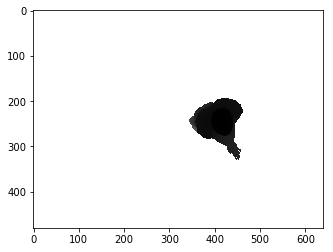

In [8]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img_src_path = "depth32/0_gen_dep_20160712194620972.png"
depth_img = Image.open(img_src_path) 

# 画像表示
img_np = np.array(depth_img)
plt.imshow(img_np, cmap="gray")

# 画像サイズ
print(img_np.shape)


In [ ]:
# convert imgs into .npy files
def ConvertIntoNpy(src, dst):
    files = os.listdir(src)
    first_img = Image.open(src + "/" + files[0])
    first_img_np = np.array(first_img)
    file_list = np.copy(first_img_np)
    file_list = file_list[np.newaxis, :]
    
    print("num of files: " + str(len(files)))
    print("img size       : " + str(first_img_np.shape))
    
    for i in range(len(files)):
        if i % 100 == 1:
            print(i)
            
        img = Image.open(src + "/" + files[i])
        img_np = np.array(img)

        # 念のため画像サイズチェック
        if img_np.shape != first_img_np.shape:
            continue
            
        img_np = img_np[np.newaxis, :]
        file_list = np.vstack((file_list, img_np))
        img.close()
        
    np.save(dst, fileList)

In [ ]:
import tensorflow as tf
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Pose_Estimation_Net:
    def __init__(self):
        self.epochs = 100000
        self.epoch_saveMetrics = 500
        #self.epoch_saveSampleImg = 500
        self.epoch_saveParameter = 1000
        
        self.X_tr = tf.placeholder(tf.float32, shape=[None, 240, 240])
        self.Y_tr = tf.placeholder(tf.float32, shape=[None, 22, 3])

        self.batch_size = 32
        img_size = 240*240 # orginal size:640*480

        self.L = self.loss()
        self.losses = {"loss":[]}

        # model architecture
    def output(self):
        with tf.variable_scope("Pose_Estimation_Net"):
            # x:[240*240*1]
            conv1 = tf.layers.conv2d(x, 3, [4,4], [2,2], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(0.0, 0.02)) # 120x120x3
            conv1 = tf.layers.batch_normalization(conv1)
            conv1 = leaky_relu(conv1)

            conv2 = tf.layers.conv2d(conv1, 6, [4,4], [2,2], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(0.0, 0.02)) # 60x60x6
            conv2 = tf.layers.batch_normalization(conv2)
            conv2 = leaky_relu(conv2)

            conv3 = tf.layers.conv2d(conv2, 12, [4,4], [2,2], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(0.0, 0.02)) # 30x30x12
            conv3 = tf.layers.batch_normalization(conv3)
            conv3 = leaky_relu(conv3)
            
            conv4 = tf.layers.conv2d(conv3, 24, [4,4], [2,2], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(0.0, 0.02)) # 15x15x24
            conv4 = tf.layers.batch_normalization(conv4)
            conv4 = leaky_relu(conv4)

            fc1 = tf.reshape(conv4, [-1, 15*15*24])
            fc1 = tf.layers.dense(fc1, 1024, kernel_initializer=tf.truncated_normal_initializer(0.0, 0.02)) # noise
            fc1 = tf.layers.batch_normalization(fc1)
            fc1 = tf.nn.relu(fc1)

            fc2 = tf.layers.dense(fc1, 2048, kernel_initializer=tf.truncated_normal_initializer(0.0, 0.02)) # noise
            fc2 = tf.layers.batch_normalization(fc2)
            fc2 = tf.nn.relu(fc2)

            fc3 = tf.layers.dense(fc2, 3*22, kernel_initializer=tf.truncated_normal_initializer(0.0, 0.02))

            y = tf.reshape(fc3, [-1, 3*22])
        return y
    def loss(self):
        output = self.output(self.X_tr)
        L = self.Y_tr - output
        L = tf.square(L)
        L = tf.reduce_mean(L)
        return L
        
    def train(self):
        opt = tf.train.AdamOptimizer()
        train_op = opt.minimize(self.L)

        saver = tf.train.Saver()
        
        with tf.Session() as sess:

            for epoch in range(self.epochs):
                # 訓練データを抜粋
                # X_mb
                
                def extractImg(img_path, label_path):
                    files_img = os.listdir(img_path)
                    rand_index = np.random.randint(0, len(files_img), size=self.batch_size)
                    # files_img[rand_index]
                    
                    
                    
                    files_label[rand_index]
                    
                    
                    
                X_mb_src_path = "./depth32"
                extractImg(X_mb_src_path)
                # Y_mb
                
                # 正規化
                _, loss_value = sess.run([train_op, self.L], feed_dict={self.X_tr: X_mb, self.Y_tr: Y_mb})

                self.losses["loss"].append(loss_value)
                
                # lossの可視化
                if epoch % self.epoch_saveMetrics == 1:
                    save_metrics(self.losses, epoch)

                # parameterのsave
                if epoch % self.epoch_saveParamter == 1:
                    path = "model_DC"
                    if not os.path.isdir(path):
                        os.makedirs(path)

                    saver.save(sess, path+"/dcgan_model" + str(epoch+epoch_pre) + ".ckpt")

In [ ]:
model = Pose_Estimation_Net()
model.train()